# Protein Classifier With KFold Cross Val

In [2]:
#Import Pandas, Numpy sklearn etc.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

AttributeError: module 'numpy' has no attribute 'version'

In [2]:
#Import Data

df_seq = pd.read_csv('pdb_data_seq.csv')
df_char = pd.read_csv('pdb_data_no_dups.csv')

In [3]:
df_char.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [4]:
df_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
#Clean data to just protiens

df_seq = df_seq.loc[df_seq['macromoleculeType'] == 'Protein']
df_char = df_char.loc[df_char['macromoleculeType'] == 'Protein']

df_char = df_char[['structureId','classification']]
df_seq = df_seq[['structureId', 'sequence']]

In [6]:
#Make one DF from data

joint = df_char.set_index('structureId').join(df_seq.set_index('structureId'))

In [7]:
joint.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [8]:
joint = joint.dropna()

C:\Users\Chris Puglisi\Anacondathreefive\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


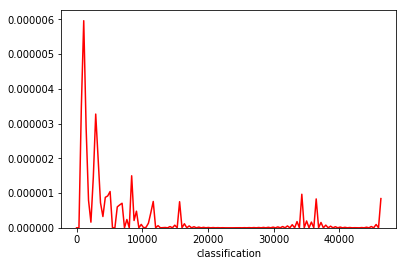

In [9]:
#use Graph to further clean data

counts = joint.classification.value_counts()
counts

plt.figure()
sns.distplot(counts, hist = False, color = 'red')
plt.show()

In [15]:
#Keep only cases with enough examples to train on

threshold = np.asarray(counts[(counts > 1000)].index)

joint = joint[joint.classification.isin(threshold)]

In [16]:
#Test train split

X = joint['sequence']
y = joint['classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [47]:
#Vectorize amino acid sequences for a numerical classification approach

vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

vect.fit(X_train)
X_kcross = vect.transform(X)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

print(vect.get_feature_names()[-20:])

['zhhh', 'ziar', 'zigi', 'ziwz', 'zkal', 'zkky', 'zknt', 'zkyh', 'zlik', 'zlzk', 'zpvm', 'zrgd', 'zrvi', 'ztvl', 'ztzk', 'zvbd', 'zvib', 'zvka', 'zwdl', 'zzvb']


In [18]:
#Machine Learning, Apply Multinomial Naive Bayes Classifier and print accuracy 

prediction = dict()
clf = MultinomialNB()
clf.fit(X_train_df, y_train)
NB_pred = clf.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.7847299527849219


In [26]:
#Solidify Model's Validity with 10 Fold Cross Validation

clf = MultinomialNB()

# use cross_val_score() to get ths scores for each train/test split
scores = cross_val_score(clf, X_kcross, y, cv = 10)
print(scores)
print()
print('Average score:', np.mean(scores))


[0.73214628 0.72399923 0.72077424 0.72636625 0.72341651 0.73291091
 0.72128313 0.73092447 0.72005384 0.72676544]

Average score: 0.7258640296069082


In [48]:
print(classification_report(y_test, NB_pred, target_names = threshold))

C:\Users\Chris Puglisi\Anacondathreefive\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 29, does not match size of target_names, 43
  .format(len(labels), len(target_names))


                                         precision    recall  f1-score   support

                              HYDROLASE       0.74      0.80      0.77       568
                            TRANSFERASE       0.69      0.74      0.71       502
                         OXIDOREDUCTASE       0.91      0.80      0.85       820
                          IMMUNE SYSTEM       0.70      0.80      0.75       604
                                  LYASE       0.55      0.76      0.64       618
          HYDROLASE/HYDROLASE INHIBITOR       0.78      0.78      0.78      9257
                          TRANSCRIPTION       0.66      0.79      0.72      2219
                          VIRAL PROTEIN       0.91      0.78      0.84      3131
                      TRANSPORT PROTEIN       0.95      0.86      0.90      1234
                                  VIRUS       0.90      0.83      0.87      1006
                      SIGNALING PROTEIN       0.94      0.87      0.90      2360
                           

# Application for Cell Final Paper

In [32]:
ier2 = [('MEVQKEAQRIMTLSVWKMYHSRMQRGGLRLHRSLQLSLVMRSAREVYLSAKVEAHQPEFPPSRRALDPRLHPPREAEVAVEVASPEAVQPPEPMDTQEEVLRVQETPALCDPPPARVSRKRRSSSDLSDGSDAGLVPSKKARLEEVEGEATSEVPDRLQLPPAQSEGAFPNLARVLQRRFSSLLNCGPAVPPPTPPTCEAKPACRPADNMLNVLVRAVVAF')]
test_ier2 = pd.Series(ier2, index = ['IER2'])
X_ier2 = X_test.append(test_ier2)

In [33]:
ier2v = vect.transform(X_ier2)

In [34]:
clf.fit(X_train_df, y_train)
prediction = clf.predict(ier2v)

In [35]:
ier2pred = pd.DataFrame(prediction)
ier2pred = ier2pred.iloc[-1]

In [36]:
ier2pred

0    TRANSFERASE
Name: 52102, dtype: object